## Part 4 Solve the equations (neglict ci)

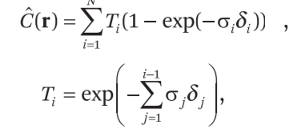

## import libraries

In [1]:
"""
Re‑creates your current world + camera demo and opens a matplotlib window.
Run:  python -m examples.demo_world
"""
import numpy as np
from nerflab import (
    Intrinsics, Camera, Box, Sphere, World, cartesian_to_spherical,
    stratified_samples_batch, plot_world, 
    CFG, pose_H, make_pose_cases, sigma_from_world,
    viz_sigma_heatmap, viz_sigma_scatter,
    nerf_opacity
)


In [2]:
# build preset dictionary
cases = make_pose_cases(axis_dist=3)

# pick a view (e.g., diagonal)
H_wc = pose_H(cases["+Z"])  
# H_wc = np.eye(4)
print(H_wc)

[[ 1.  0. -0.  0.]
 [-0.  1. -0.  0.]
 [ 0.  0.  1.  3.]
 [ 0.  0.  0.  1.]]


In [3]:
# --- camera ------------------------------------------------------------------
# H_wc = np.eye(4, dtype=np.float32)        # simple origin‑facing camera
intr  = Intrinsics(**CFG.intrinsics.__dict__)
cam   = Camera(intr, H_wc,
               t_bounds=(CFG.rays.t_near, CFG.rays.t_far))

# --- sample rays -------------------------------------------------------------
O_w, D_w = cam.get_rays(frame="world")
t, delta, pts = stratified_samples_batch(
    O_w, D_w, CFG.rays.t_near, CFG.rays.t_far,
    N=CFG.rays.N, deterministic=CFG.rays.deterministic
)
print("points shape:", pts.shape)


points shape: (307200, 20, 3)


density at (0,2,1): 0.0


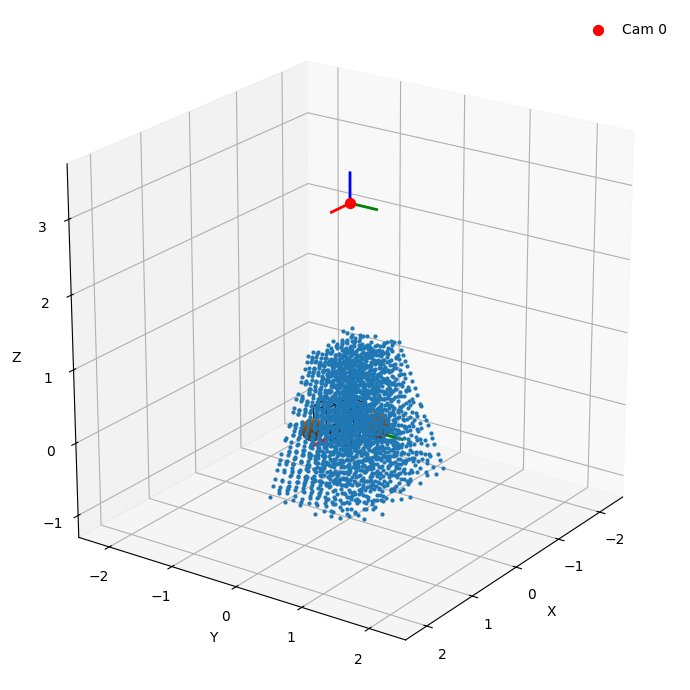

In [4]:
# --- build world -------------------------------------------------------------
# ------------------------------------------------------------
# Scaled‑down world  (factor = 0.20)
# ------------------------------------------------------------
world = World()

# Boxes
world.add_shape(Box(center=(-0.30,  -0.2, 0.0), size=(0.28, 0.28, 0.28)))
world.add_shape(Box(center=( 0.28,  0.12, 0.0), size=(0.20, 0.32, 0.20)))
world.add_shape(Box(center=( 0.00, -0.40, 0.0), size=(0.20, 0.20, 0.36)))

# Spheres
world.add_shape(Sphere(center=(-0.16,  0.30, 0.0), radius=0.17))
world.add_shape(Sphere(center=( 0.40, -0.30, 0.0), radius=0.14))

# Check the density of a point
x,y,z = (0,2,1)
print("density at (0,2,1):", world.density(x, y, z))

from nerflab.viz import viz_cfg
viz_cfg.figsize = (9, 7)
viz_cfg.default_alpha = 0.5
# --- visualise ---------------------------------------------------------------

plot_world(
    world,
    cameras=[cam],
    draw_rays=True,          # we’ll show only the cloud
    ray_mode="points",
    ray_step=3000,              # keeps every 40‑th pixel row in the cloud
    points=pts,
    point_size=4,
    
)


In [5]:
sigma = sigma_from_world(world, pts)

In [6]:
print(sigma.shape)
print(sigma.min(), sigma.max())

(307200, 20)
0.0 10000000.0


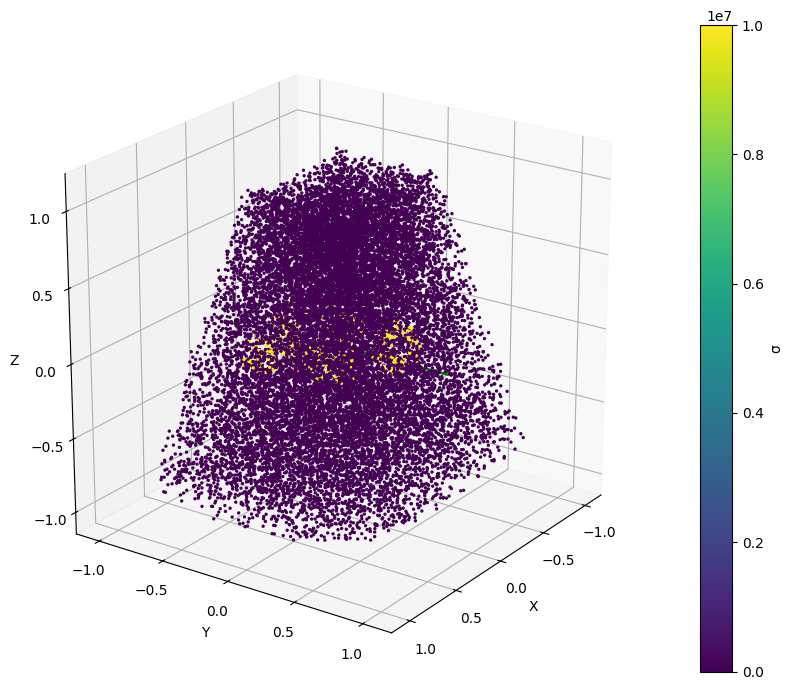

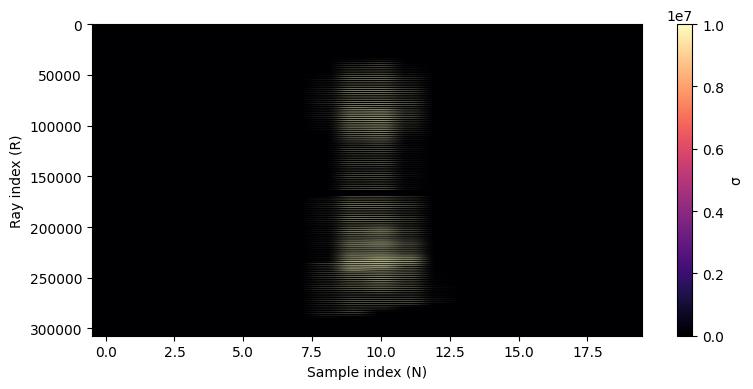

In [7]:
viz_sigma_scatter(pts, sigma)
viz_sigma_heatmap(sigma)


In [8]:
T, w, C = nerf_opacity(sigma, delta)


In [9]:
print(np.unique(C))
print(C.min(), C.max())

[0. 1.]
0.0 1.0


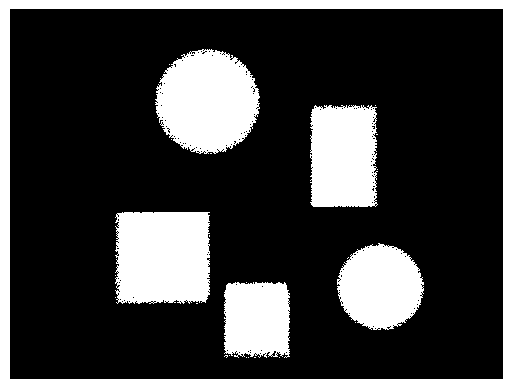

In [10]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Literal, Optional
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

h, w = int(intr.height), int(intr.width)
im = np.round(C.reshape(h,  w), 2)

# im is 0/1 array
cmap = ListedColormap(['black', 'white'])
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

plt.imshow(im, cmap=cmap, norm=norm, interpolation='nearest')
plt.axis('off')
plt.show()


In [11]:
print(t.shape)
print(sigma.shape)
indcies, x = np.where(sigma !=0)

(307200, 20)
(307200, 20)


In [12]:
print(f"# rays hit {indcies.shape}")
print(np.unique(x))

# rays hit (131376,)
[ 8  9 10 11 12]


208245


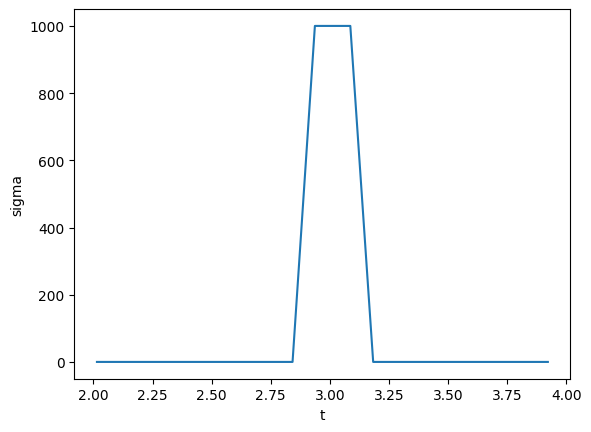

In [13]:
idx = np.random.choice(indcies)
print(idx)
plt.plot(t[idx], np.clip(sigma[idx], 0, 1000))
plt.xlabel("t")
plt.ylabel("sigma")
plt.show()

In [14]:
# Debug once

bad_sigma = ~np.isfinite(sigma)
bad_delta = ~np.isfinite(delta)
print("bad sigma:", bad_sigma.any(), "bad delta:", bad_delta.any())


bad sigma: False bad delta: False
